In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# --- 1. Data Loading ---
print("--- Data Loading ---")
try:
    df = pd.read_csv('zomato.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: zomato.csv not found. Please ensure the file is in the correct directory.")
    exit() # Exit if the file is not found

# Make a copy to preserve original if needed (optional)
df_original = df.copy()

--- Data Loading ---
Dataset loaded successfully.


In [3]:
# --- 2. Initial Data Inspection ---
print("\n--- Initial Data Inspection ---")
print("DataFrame Shape:", df.shape)
print("\nDataFrame Columns:\n", df.columns.tolist())
print("\nDataFrame Info:")
df.info()
print("\nDataFrame Head:\n", df.head())
print("\nMissing Values Before Cleaning:\n", df.isnull().sum())


--- Initial Data Inspection ---
DataFrame Shape: (51717, 17)

DataFrame Columns:
 ['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes', 'phone', 'location', 'rest_type', 'dish_liked', 'cuisines', 'approx_cost(for two people)', 'reviews_list', 'menu_item', 'listed_in(type)', 'listed_in(city)']

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-nu

In [5]:
# --- 3. Core Data Cleaning & Preparation ---
print("\n--- Core Data Cleaning & Preparation ---")

# Rename columns for easier access (e.g., remove spaces and special characters)
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True).str.lower()
# IMPORTANT: Ensure 'approxcostfortwopeople' matches your exact column name after standardization
df.rename(columns={'approx_costfortwopeople': 'approx_cost'}, inplace=True)
print("Columns after renaming and standardization:", df.columns.tolist())

# Drop irrelevant columns (RETAINING 'approx_cost' and 'votes')
columns_to_drop = ['url', 'address', 'phone', 'menu_item', 'dish_liked', 'reviews_list']
df.drop(columns=columns_to_drop, errors='ignore', inplace=True)
print(f"Dropped columns: {columns_to_drop}. Remaining columns count: {df.shape[1]}")

# Cleaning 'rate' column (with the 'astype(str)' fix)
print("\nCleaning 'rate' column...")
df.dropna(axis=0, subset=['rate'], inplace=True) # Drop rows where 'rate' is NaN
df['rate'] = df['rate'].astype(str) # **Crucial fix: Convert to string before operations**
df['rate'] = df['rate'].apply(lambda x: x.replace('/5', '').strip()) # Remove '/5' and strip whitespace
df['rate'] = df['rate'].replace(['NEW', '-'], np.nan) # Replace 'NEW' and '-' with NaN
df['rate'] = pd.to_numeric(df['rate'], errors='coerce') # Convert to numeric, coercing errors to NaN
df['rate'].fillna(df['rate'].mean(), inplace=True) # Fill remaining NaN values
print("Cleaned 'rate' column info:\n", df['rate'].describe())

# Cleaning 'approx_cost' column
print("\nCleaning 'approx_cost' column...")
df['approx_cost'] = df['approx_cost'].astype(str).str.replace(',', '', regex=False) # Remove commas
df['approx_cost'] = pd.to_numeric(df['approx_cost'], errors='coerce') # Convert to numeric
df['approx_cost'].fillna(df['approx_cost'].median(), inplace=True) # Fill NaN with median
print("Cleaned 'approx_cost' column info:\n", df['approx_cost'].describe())

# Cleaning 'votes' column
print("\nCleaning 'votes' column...")
df['votes'] = pd.to_numeric(df['votes'], errors='coerce') # Convert to numeric
df['votes'].fillna(df['votes'].mean(), inplace=True) # Fill NaN with mean
print("Cleaned 'votes' column info:\n", df['votes'].describe())

# Outlier handling using IQR method for 'votes' and 'approx_cost'
print("\nHandling outliers for 'votes' and 'approx_cost'...")
for col in ['votes', 'approx_cost']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    print(f"Outliers handled for {col}. New min: {df[col].min():.2f}, New max: {df[col].max():.2f}")

# Convert online_order and book_table to numeric (1/0)
df['online_order'] = df['online_order'].map({'Yes': 1, 'No': 0})
df['book_table'] = df['book_table'].map({'Yes': 1, 'No': 0})

# Standardize 'location' and 'rest_type' by converting to lower case and stripping whitespace
df['location'] = df['location'].str.lower().str.strip()
df['rest_type'] = df['rest_type'].str.lower().str.strip()
df['cuisines'] = df['cuisines'].str.lower().str.strip() # Ensure cuisines are also standardized


print("\nMissing Values After Core Cleaning:\n", df.isnull().sum())


--- Core Data Cleaning & Preparation ---
Columns after renaming and standardization: ['name', 'online_order', 'book_table', 'rate', 'votes', 'location', 'rest_type', 'cuisines', 'approx_cost', 'listed_intype', 'listed_incity']
Dropped columns: ['url', 'address', 'phone', 'menu_item', 'dish_liked', 'reviews_list']. Remaining columns count: 11

Cleaning 'rate' column...
Cleaned 'rate' column info:
 count    43942.000000
mean         3.700449
std          0.428947
min          1.800000
25%          3.400000
50%          3.700449
75%          4.000000
max          4.900000
Name: rate, dtype: float64

Cleaning 'approx_cost' column...
Cleaned 'approx_cost' column info:
 count    43942.000000
mean       593.442856
std        457.573874
min         40.000000
25%        300.000000
50%        450.000000
75%        700.000000
max       6000.000000
Name: approx_cost, dtype: float64

Cleaning 'votes' column...
Cleaned 'votes' column info:
 count    43942.000000
mean       333.430954
std        862

In [6]:
# --- 4. Advanced Data Cleaning (Categorical Features: Grouping Infrequent Categories) ---
print("\n--- Advanced Data Cleaning (Categorical Features) ---")

# Cleaning 'rest_type' Column: Grouping infrequent types into 'others'
rest_types = df['rest_type'].value_counts()
rest_types_lessthan1000 = rest_types[rest_types < 1000]

def handle_rest_type(value):
    if value in rest_types_lessthan1000.index:
        return 'others'
    else:
        return value

df['rest_type'] = df['rest_type'].apply(handle_rest_type)
print("Unique Restaurant Types after grouping 'others':\n", df['rest_type'].value_counts())
print("-" * 50)

# Cleaning 'location' Column: Grouping infrequent locations into 'others'
location = df['location'].value_counts()
location_lessthan300 = location[location < 300]

def handle_location(value):
    if value in location_lessthan300.index:
        return 'others'
    else:
        return value

df['location'] = df['location'].apply(handle_location)
print("Unique Locations after grouping 'others':\n", df['location'].value_counts())
print("-" * 50)

# Cleaning 'cuisines' Column: Grouping infrequent cuisines into 'others'
cuisines = df['cuisines'].value_counts()
cuisines_lessthan100 = cuisines[cuisines < 100]

def handle_cuisines(value):
    if value in cuisines_lessthan100.index:
        return 'others'
    else:
        return value

df['cuisines'] = df['cuisines'].apply(handle_cuisines)
print("Unique Cuisines after grouping 'others':\n", df['cuisines'].value_counts())
print("-" * 50)


--- Advanced Data Cleaning (Categorical Features) ---
Unique Restaurant Types after grouping 'others':
 rest_type
quick bites           15073
casual dining          9923
others                 8925
cafe                   3527
dessert parlor         1939
delivery               1791
takeaway, delivery     1472
casual dining, bar     1141
Name: count, dtype: int64
--------------------------------------------------
Unique Locations after grouping 'others':
 location
others                   4683
btm                      4261
koramangala 5th block    2381
hsr                      2128
indiranagar              1936
jp nagar                 1849
jayanagar                1718
whitefield               1693
marathahalli             1503
bannerghatta road        1324
koramangala 6th block    1111
koramangala 7th block    1089
brigade road             1084
bellandur                1078
koramangala 1st block     965
electronic city           964
sarjapur road             919
ulsoor                

In [7]:
# --- 5. Calculated Metrics (KPIs) ---
print("\n--- Calculated Metrics ---")


--- Calculated Metrics ---


In [8]:
# 5.1. Total Sales (Approximation)
total_sales_approx = df['approx_cost'].sum()
print(f"\nTotal Sales (Approximation based on approx_cost for two people): ₹{total_sales_approx:,.2f}")



Total Sales (Approximation based on approx_cost for two people): ₹24,372,416.00


In [9]:
# 5.2. Average Order Value (AOV) (Approximation)
average_order_value_approx = df['approx_cost'].mean()
print(f"Average Order Value (Approximation based on approx_cost for two people): ₹{average_order_value_approx:,.2f}")

Average Order Value (Approximation based on approx_cost for two people): ₹554.65


In [10]:
# Sales by Region (using approx_cost as a proxy) - Tabular Display
sales_by_region = df.groupby('location')['approx_cost'].sum().sort_values(ascending=False)
sales_by_region_df = sales_by_region.head(10).reset_index()
sales_by_region_df.columns = ['Location', 'Approximate Sales (₹)']
print("\nTop 10 Locations by Approximate Sales:\n", sales_by_region_df.to_string(index=False))


Top 10 Locations by Approximate Sales:
              Location  Approximate Sales (₹)
               others              2288336.0
                  btm              1754600.0
koramangala 5th block              1561550.0
          indiranagar              1248940.0
                  hsr              1056530.0
           whitefield              1017650.0
             jp nagar              1012700.0
            jayanagar               844950.0
         marathahalli               790650.0
              mg road               745100.0


In [11]:
# Sales by Restaurant Type (using approx_cost as a proxy) - Tabular Display
sales_by_rest_type = df.groupby('rest_type')['approx_cost'].sum().sort_values(ascending=False)
sales_by_rest_type_df = sales_by_rest_type.head(10).reset_index()
sales_by_rest_type_df.columns = ['Restaurant Type', 'Approximate Sales (₹)']
print("\nTop 10 Restaurant Types by Approximate Sales:\n", sales_by_rest_type_df.to_string(index=False))


Top 10 Restaurant Types by Approximate Sales:
    Restaurant Type  Approximate Sales (₹)
     casual dining              7610600.0
            others              6233040.0
       quick bites              4938450.0
              cafe              2189200.0
casual dining, bar              1276650.0
          delivery               803700.0
    dessert parlor               663800.0
takeaway, delivery               591026.0


In [12]:
# --- 6. Comprehensive Exploratory Data Analysis (EDA) & Key Visualizations ---
print("\n--- Comprehensive Exploratory Data Analysis (EDA) & Key Visualizations ---")


--- Comprehensive Exploratory Data Analysis (EDA) & Key Visualizations ---


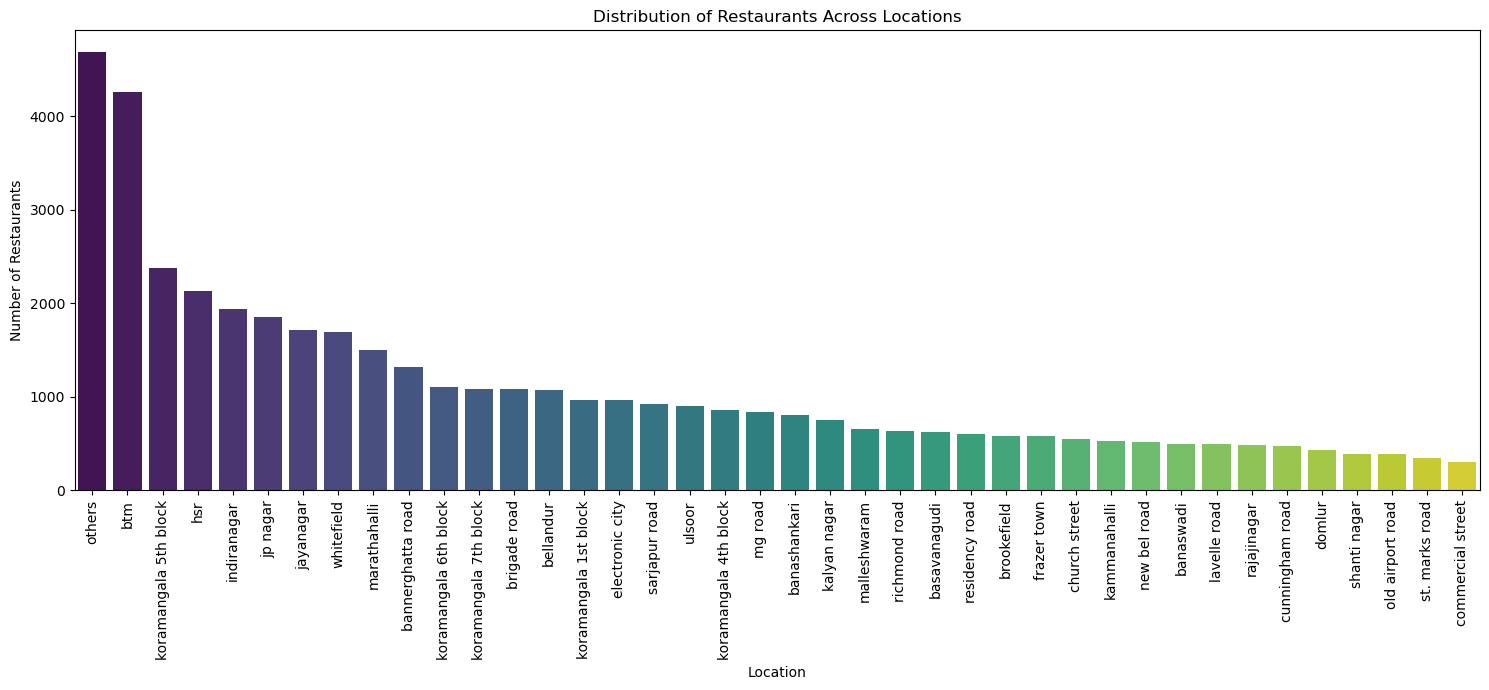

In [13]:
# 6.1. Distribution of Restaurants Across Locations
location_counts = df['location'].value_counts()
plt.figure(figsize=(15, 7))
sns.barplot(x=location_counts.index, y=location_counts.values, palette='viridis')
plt.title('Distribution of Restaurants Across Locations')
plt.xlabel('Location')
plt.ylabel('Number of Restaurants')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


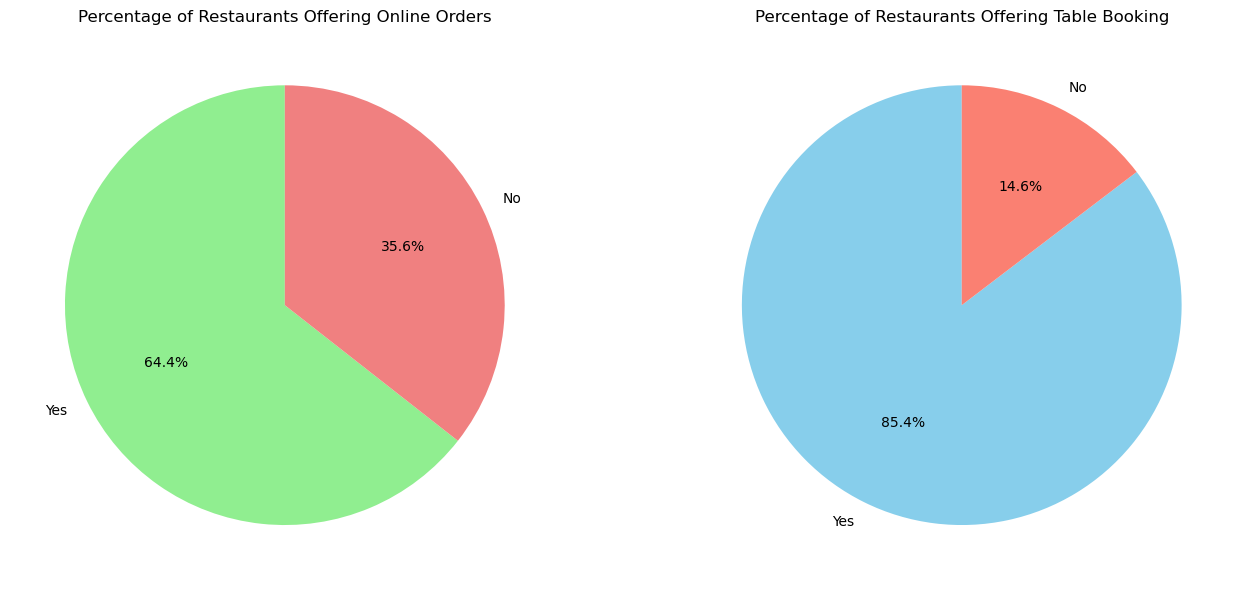

In [14]:

# 6.2. Online Order and Table Booking Facilities Distribution (Pie Charts)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

df['online_order'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[0], colors=['lightgreen', 'lightcoral'], startangle=90, labels=['Yes', 'No'])
axes[0].set_title('Percentage of Restaurants Offering Online Orders')
axes[0].set_ylabel('')

df['book_table'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[1], colors=['skyblue', 'salmon'], startangle=90, labels=['Yes', 'No'])
axes[1].set_title('Percentage of Restaurants Offering Table Booking')
axes[1].set_ylabel('')
plt.tight_layout()
plt.show()

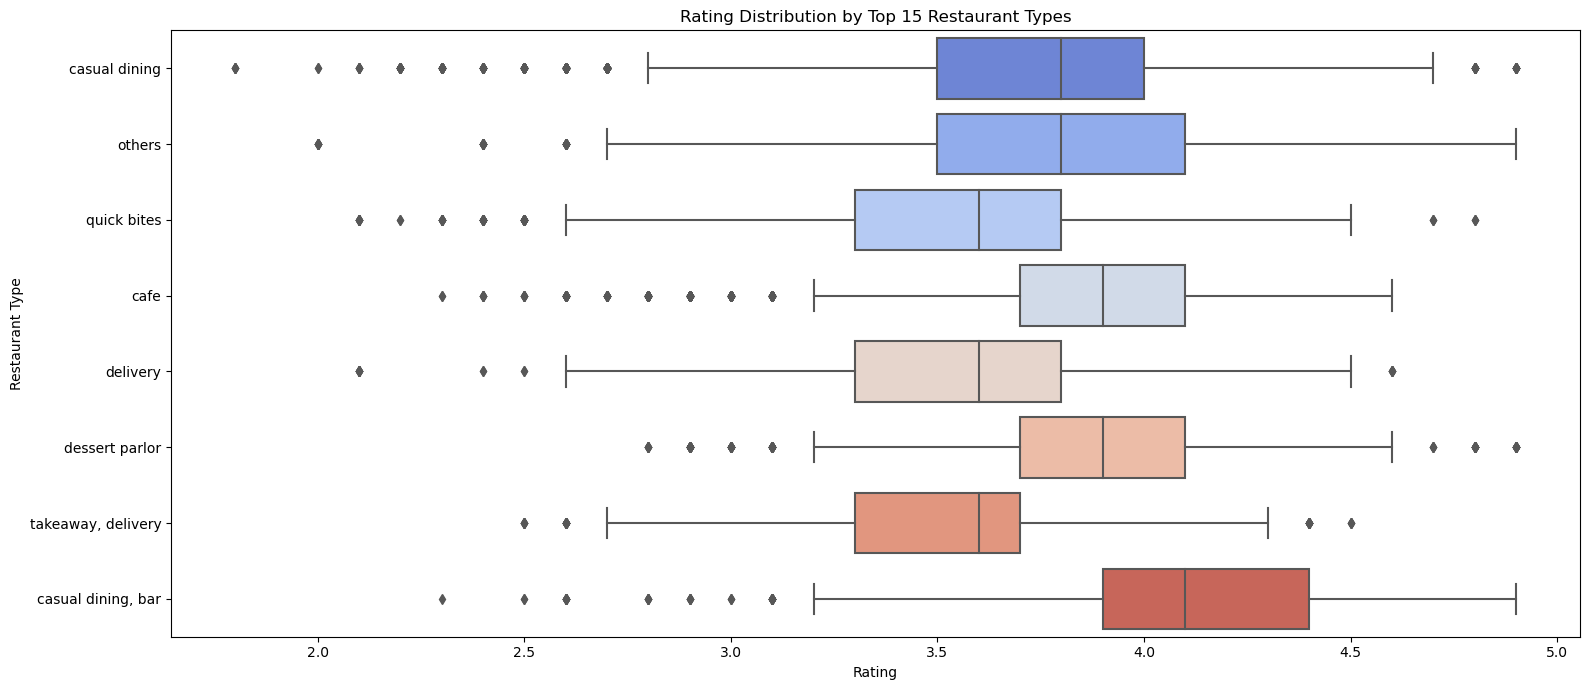

In [15]:
# 6.3. Rating Trends by Restaurant Type (Box Plot) - From earlier comprehensive code
plt.figure(figsize=(16, 7))
top_rest_types = df['rest_type'].value_counts().index[:15] # Consider top 15 for readability
sns.boxplot(y='rest_type', x='rate', data=df[df['rest_type'].isin(top_rest_types)], palette='coolwarm')
plt.title('Rating Distribution by Top 15 Restaurant Types')
plt.xlabel('Rating')
plt.ylabel('Restaurant Type')
plt.tight_layout()
plt.show()

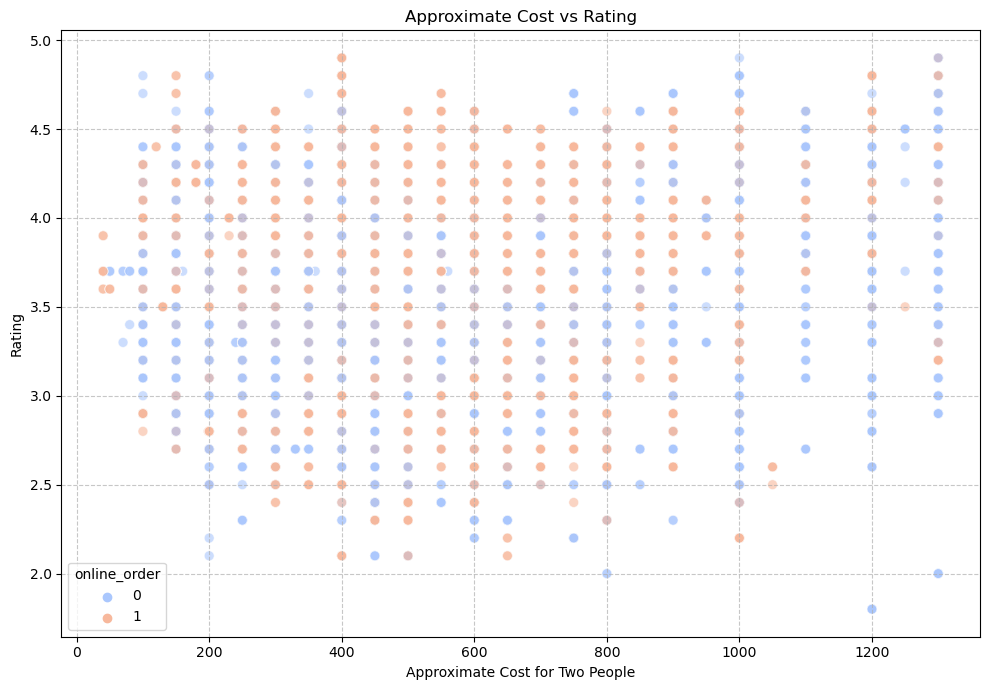

In [16]:
# 6.4. Cost vs Rating Scatterplot (from earlier comprehensive code)
plt.figure(figsize=(10, 7))
sns.scatterplot(x='approx_cost', y='rate', data=df, alpha=0.6, hue='online_order', palette='coolwarm', s=50)
plt.title('Approximate Cost vs Rating')
plt.xlabel('Approximate Cost for Two People')
plt.ylabel('Rating')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

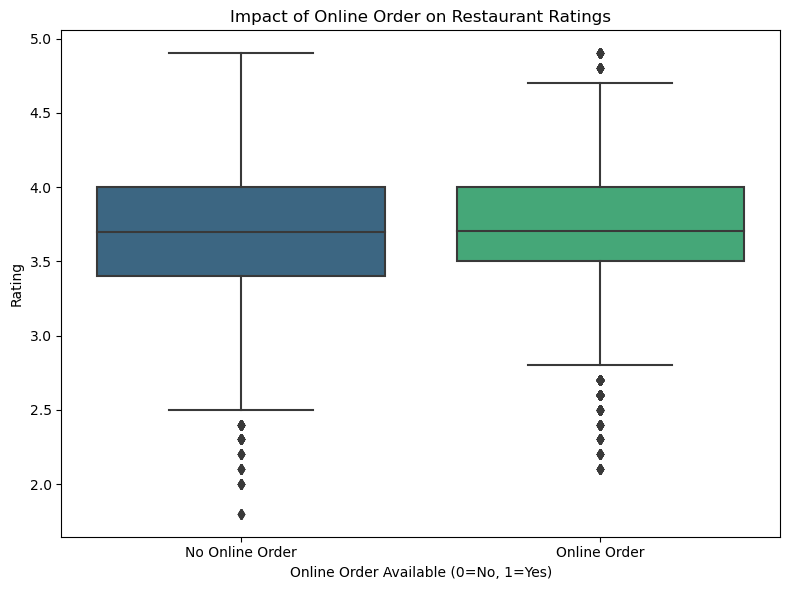

In [17]:
# 6.5. Online Order vs Rating (Box Plot)
plt.figure(figsize=(8, 6))
sns.boxplot(x='online_order', y='rate', data=df, palette='viridis')
plt.title('Impact of Online Order on Restaurant Ratings')
plt.xlabel('Online Order Available (0=No, 1=Yes)')
plt.ylabel('Rating')
plt.xticks([0, 1], ['No Online Order', 'Online Order'])
plt.tight_layout()
plt.show()

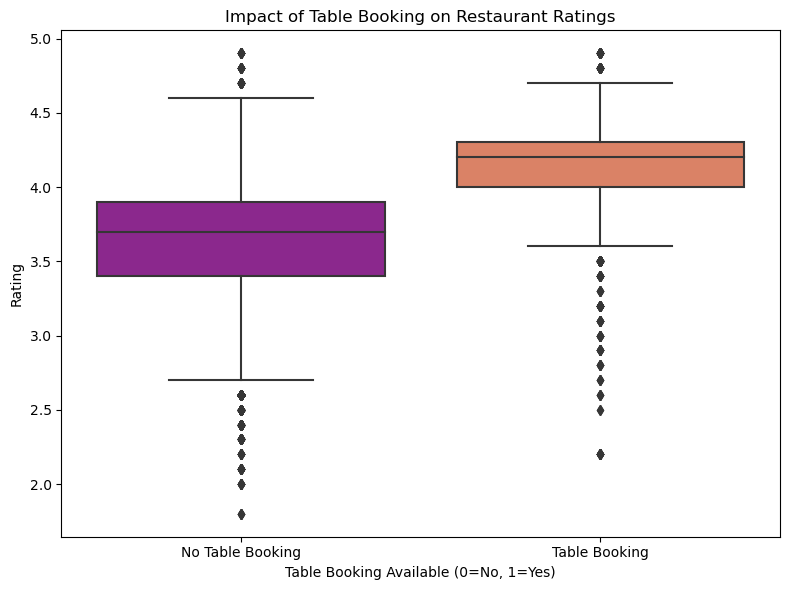

In [18]:
# 6.6. Book Table vs Rating (Box Plot)
plt.figure(figsize=(8, 6))
sns.boxplot(x='book_table', y='rate', data=df, palette='plasma')
plt.title('Impact of Table Booking on Restaurant Ratings')
plt.xlabel('Table Booking Available (0=No, 1=Yes)')
plt.ylabel('Rating')
plt.xticks([0, 1], ['No Table Booking', 'Table Booking'])
plt.tight_layout()
plt.show()

In [19]:
# 6.7. Most Rated Restaurant(s) in Each Location
df['rank_max'] = df.groupby('location')['rate'].rank(method='min', ascending=False)
result_top_rated = df[df['rank_max'] == 1].sort_values(by='rate', ascending=False)
print("\n--- Top Rated Restaurant(s) in Each Location (Rate = 1st Rank) ---")
print(result_top_rated[['location', 'name', 'rate', 'rank_max']].to_string(index=False))
print("-" * 50)


--- Top Rated Restaurant(s) in Each Location (Rate = 1st Rank) ---
             location                                                                             name  rate  rank_max
           whitefield                                                                         Flechazo   4.9       1.0
                  btm                                                        AB's - Absolute Barbecues   4.9       1.0
         brigade road                                                           Belgian Waffle Factory   4.9       1.0
koramangala 5th block                                                   Asia Kitchen By Mainland China   4.9       1.0
koramangala 5th block                                                   Asia Kitchen By Mainland China   4.9       1.0
koramangala 5th block                                                   Asia Kitchen By Mainland China   4.9       1.0
koramangala 5th block                                                   Asia Kitchen By Mainland Ch

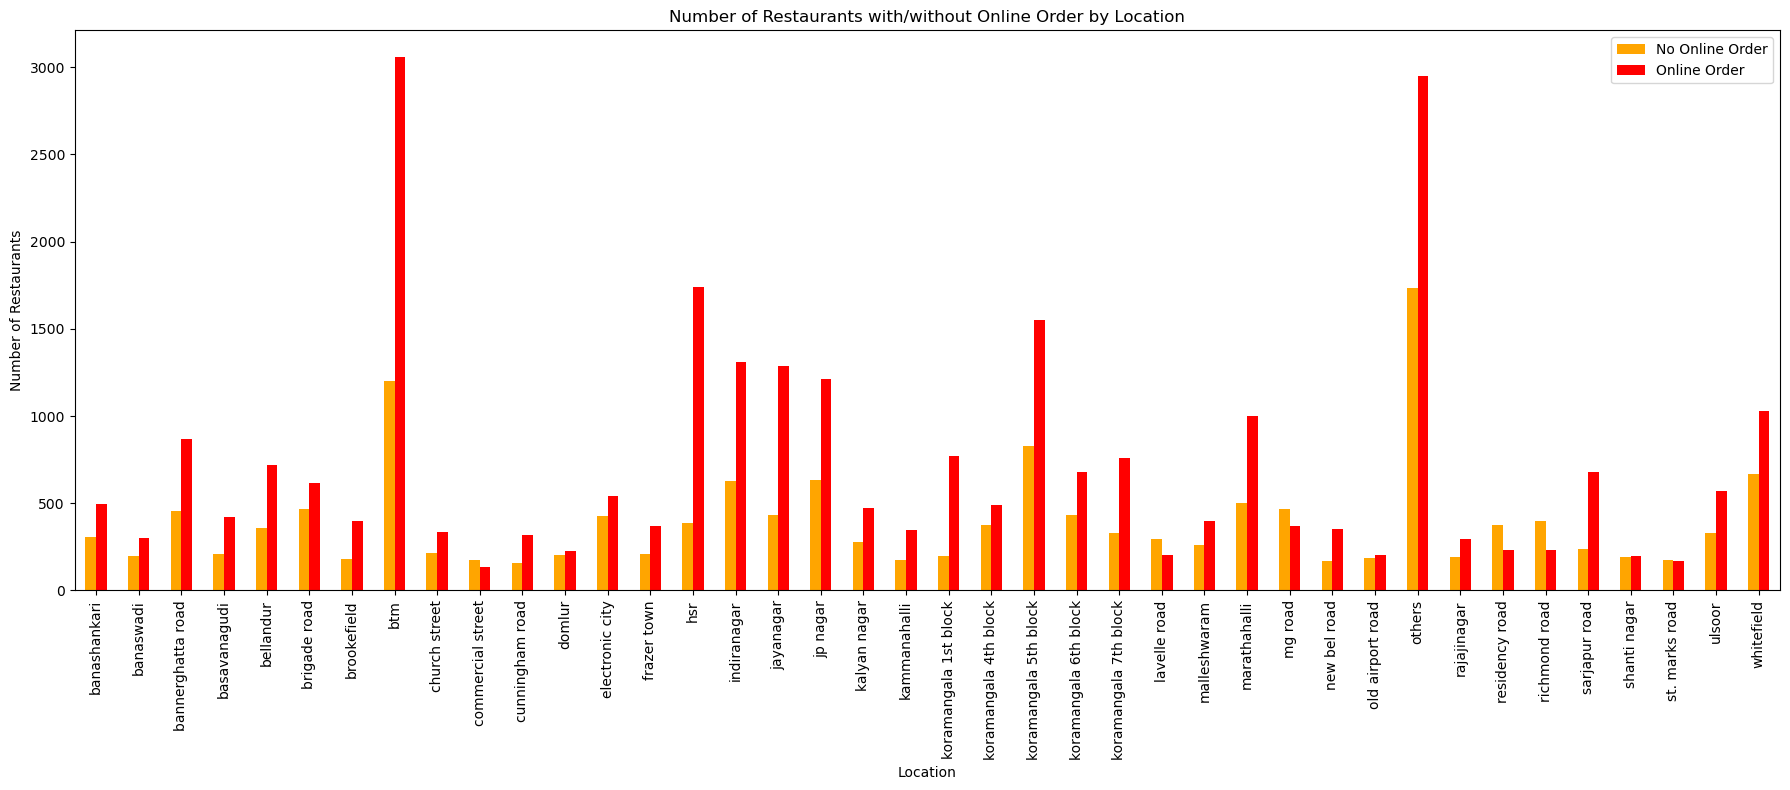

In [20]:
# 6.8. Online Order Facility Distribution by Location
locations_grouped_online = df.groupby(['location','online_order']).agg(count=('online_order','count')).reset_index()
locations_grouped_online_pivot = locations_grouped_online.pivot_table(
    index='location', columns='online_order', values='count', fill_value=0
).reset_index()
locations_grouped_online_pivot.columns = ['location', 'No Online Order', 'Online Order']

locations_grouped_online_pivot.plot(kind='bar', x='location', figsize=(18, 8),
                                    color=['orange', 'red'],
                                    title='Number of Restaurants with/without Online Order by Location')
plt.xlabel('Location')
plt.ylabel('Number of Restaurants')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

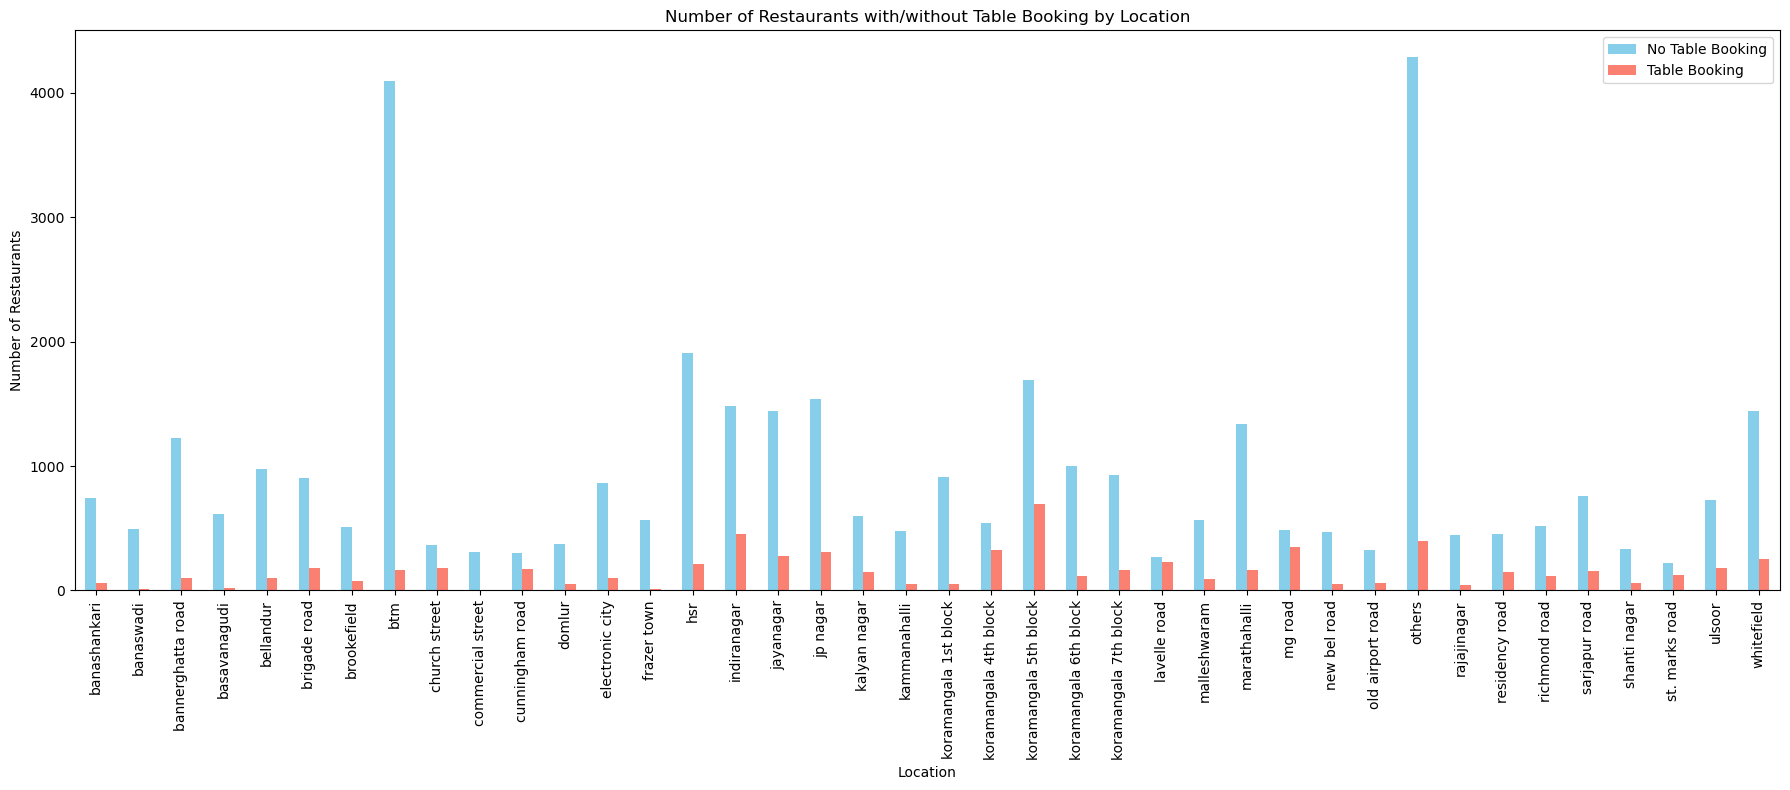

In [21]:
# 6.9. Table Facility Distribution by Location
locations_grouped_book = df.groupby(['location','book_table']).agg(count=('book_table','count')).reset_index()
locations_grouped_book_pivot = locations_grouped_book.pivot_table(
    index='location', columns='book_table', values='count', fill_value=0
).reset_index()
locations_grouped_book_pivot.columns = ['location', 'No Table Booking', 'Table Booking']

locations_grouped_book_pivot.plot(kind='bar', x='location', figsize=(18, 8),
                                  color=['skyblue', 'salmon'],
                                  title='Number of Restaurants with/without Table Booking by Location')
plt.xlabel('Location')
plt.ylabel('Number of Restaurants')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [22]:
# 6.10. Restaurant Type Distribution by Location
locations_grouped_type = df.groupby(['location','rest_type']).agg(count=('name','count')).reset_index()
print("\nGrouped counts of Restaurant Types by Location (Head):\n", locations_grouped_type.head())


Grouped counts of Restaurant Types by Location (Head):
        location           rest_type  count
0  banashankari                cafe     85
1  banashankari       casual dining    145
2  banashankari  casual dining, bar      1
3  banashankari            delivery     23
4  banashankari      dessert parlor     44


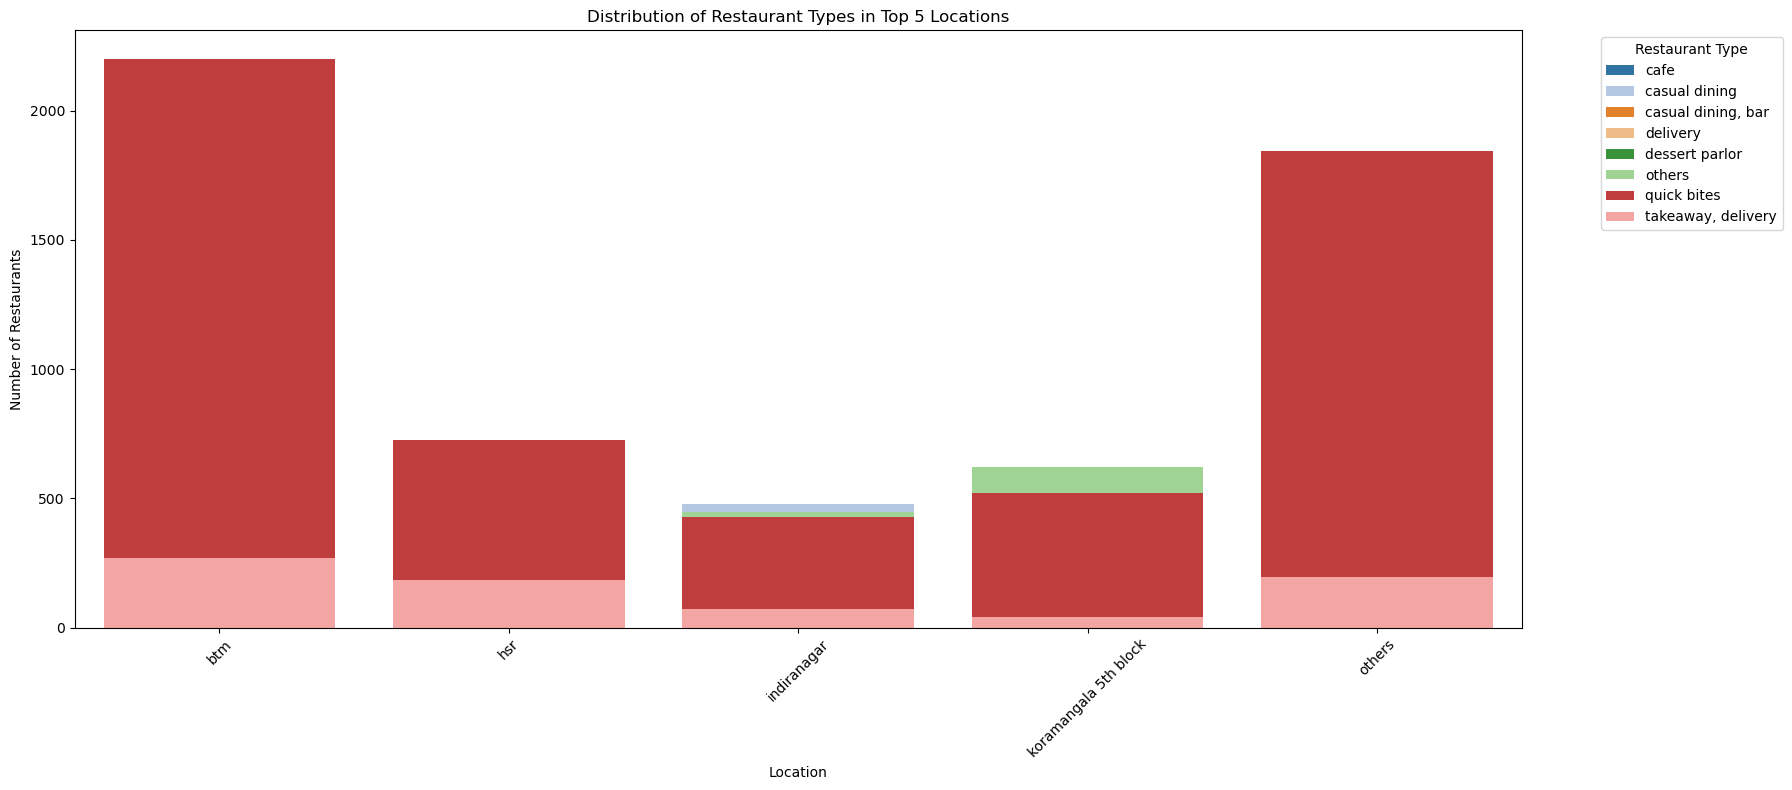

In [23]:
# Visualizing top 5 locations with restaurant types for example:
top_5_locations = df['location'].value_counts().head(5).index
df_top_5_loc = locations_grouped_type[locations_grouped_type['location'].isin(top_5_locations)]

plt.figure(figsize=(18, 8))
sns.barplot(data=df_top_5_loc, x='location', y='count', hue='rest_type', dodge=False, palette='tab20')
plt.xlabel('Location')
plt.ylabel('Number of Restaurants')
plt.title('Distribution of Restaurant Types in Top 5 Locations')
plt.xticks(rotation=45)
plt.legend(title='Restaurant Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


--- Deeper Cuisine-Specific Analysis ---


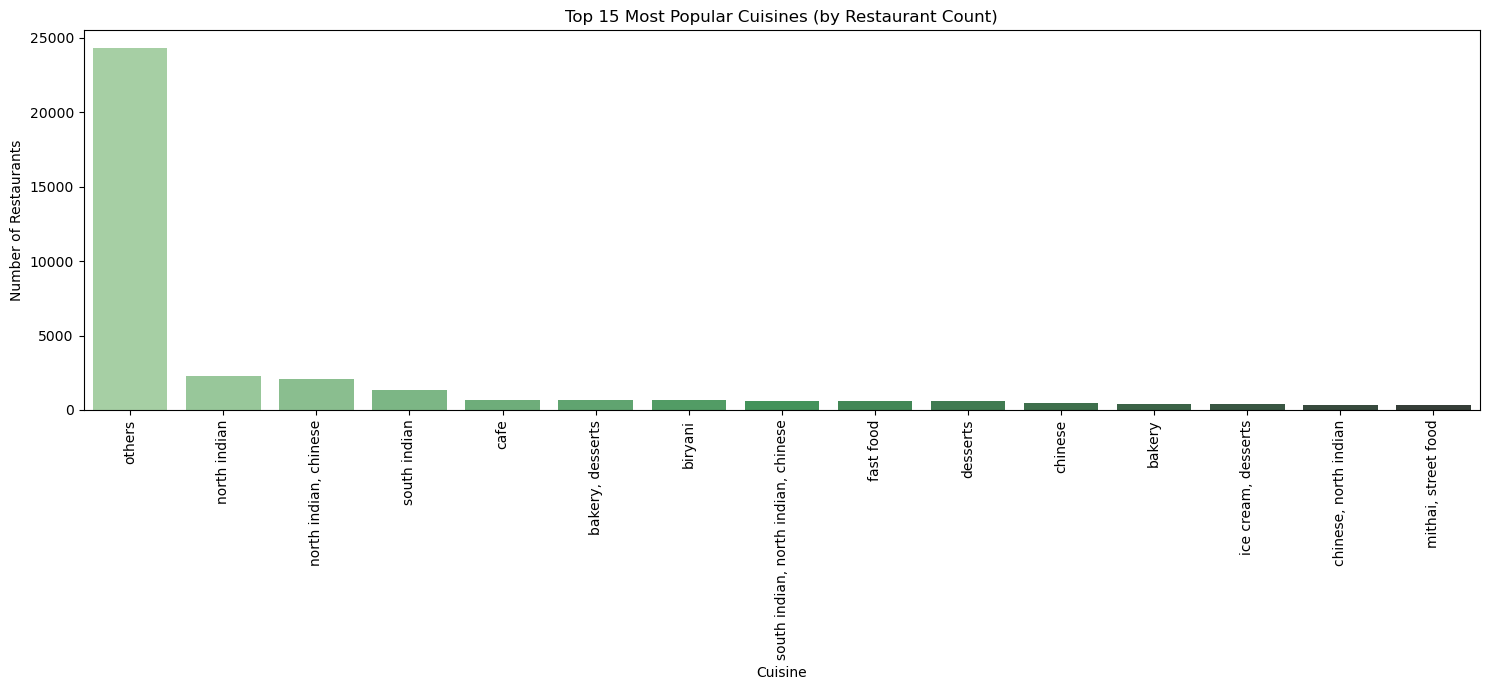

In [24]:
# 7.1. Deeper Cuisine-Specific Analysis
print("\n--- Deeper Cuisine-Specific Analysis ---")
# Most Popular Cuisines (by count)
cuisine_counts = df['cuisines'].value_counts().head(15) # Top 15 for visualization
plt.figure(figsize=(15, 7))
sns.barplot(x=cuisine_counts.index, y=cuisine_counts.values, palette='Greens_d')
plt.title('Top 15 Most Popular Cuisines (by Restaurant Count)')
plt.xlabel('Cuisine')
plt.ylabel('Number of Restaurants')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

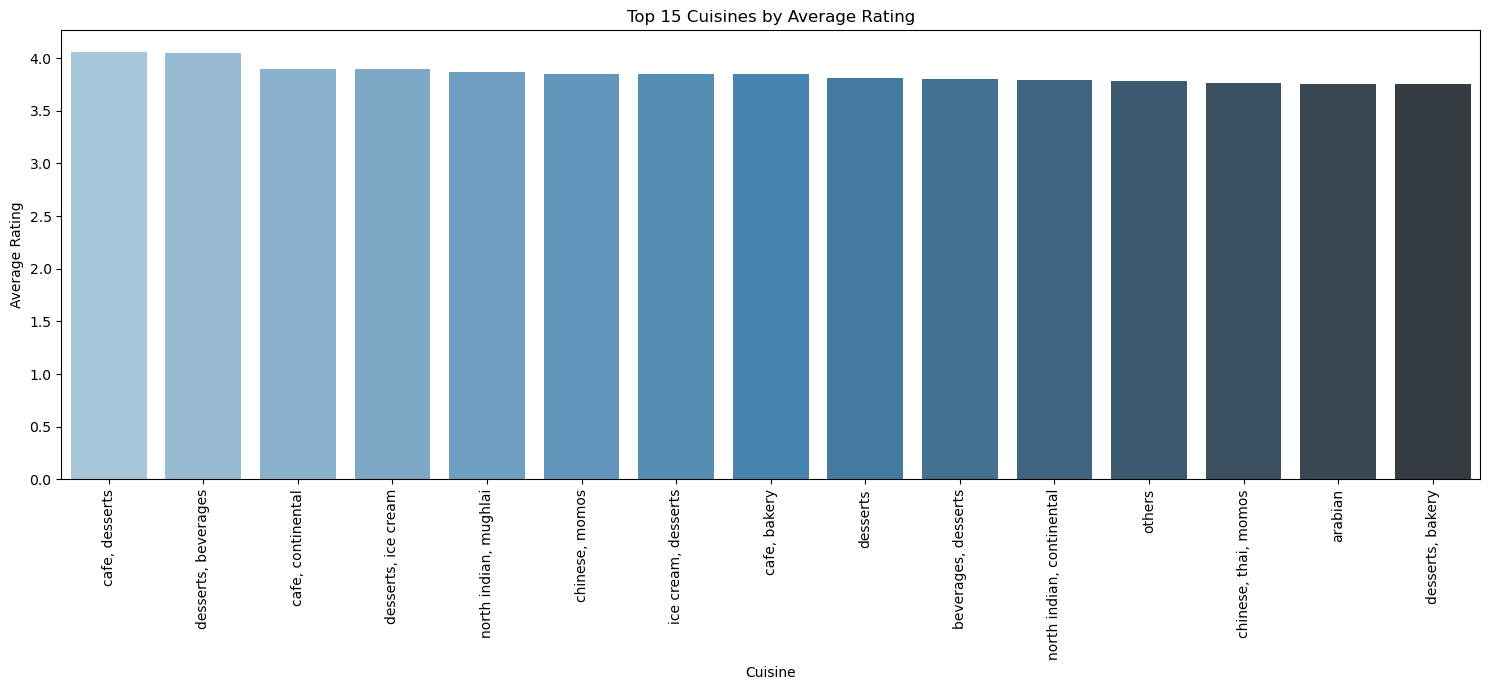

In [25]:
# Average Rating by Cuisine
avg_rating_by_cuisine = df.groupby('cuisines')['rate'].mean().sort_values(ascending=False).head(15)
plt.figure(figsize=(15, 7))
sns.barplot(x=avg_rating_by_cuisine.index, y=avg_rating_by_cuisine.values, palette='Blues_d')
plt.title('Top 15 Cuisines by Average Rating')
plt.xlabel('Cuisine')
plt.ylabel('Average Rating')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

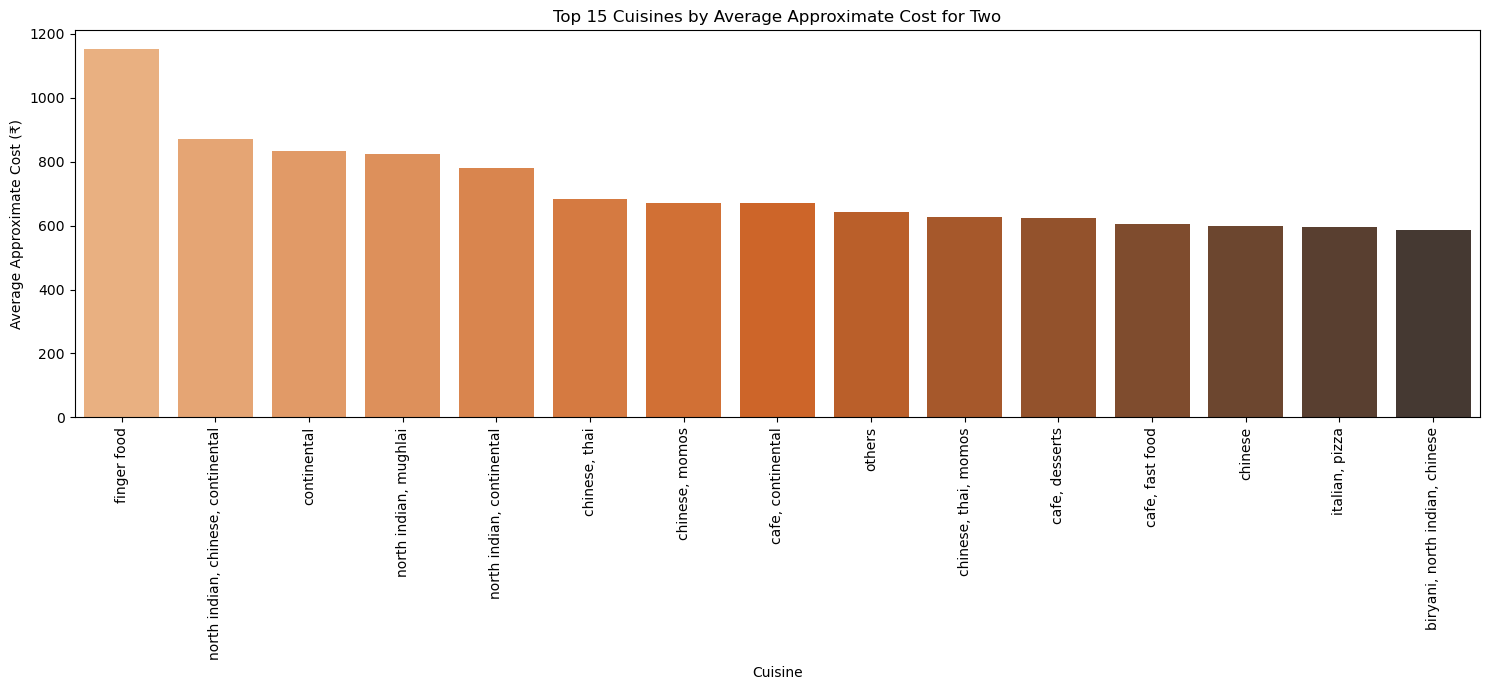

In [26]:
# Average Cost by Cuisine
avg_cost_by_cuisine = df.groupby('cuisines')['approx_cost'].mean().sort_values(ascending=False).head(15)
plt.figure(figsize=(15, 7))
sns.barplot(x=avg_cost_by_cuisine.index, y=avg_cost_by_cuisine.values, palette='Oranges_d')
plt.title('Top 15 Cuisines by Average Approximate Cost for Two')
plt.xlabel('Cuisine')
plt.ylabel('Average Approximate Cost (₹)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


--- Overall Data Distributions ---


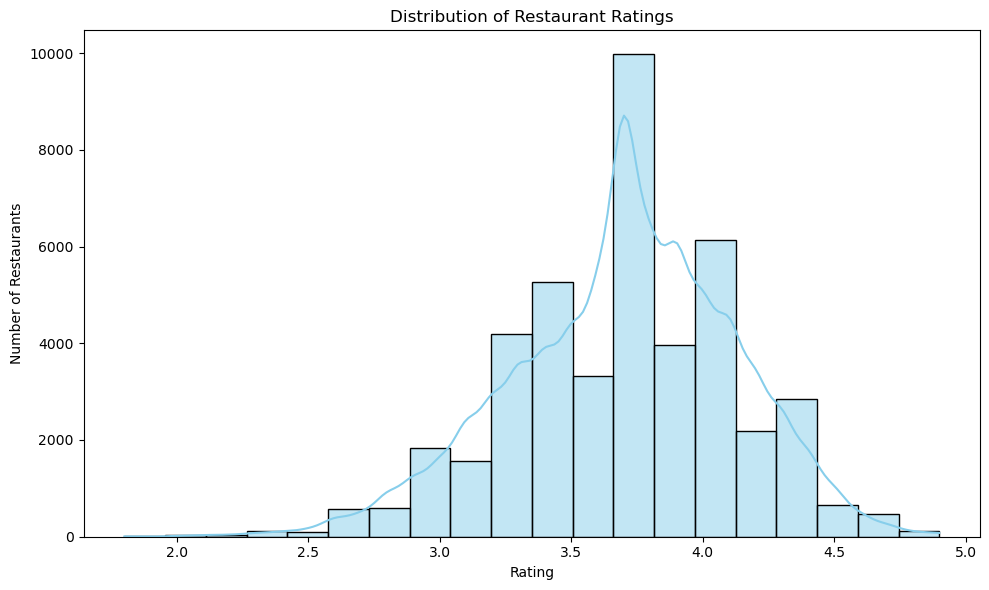

In [27]:
# 7.2. Overall Data Distributions
print("\n--- Overall Data Distributions ---")
# Distribution of Ratings (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(df['rate'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Restaurant Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Restaurants')
plt.tight_layout()
plt.show()

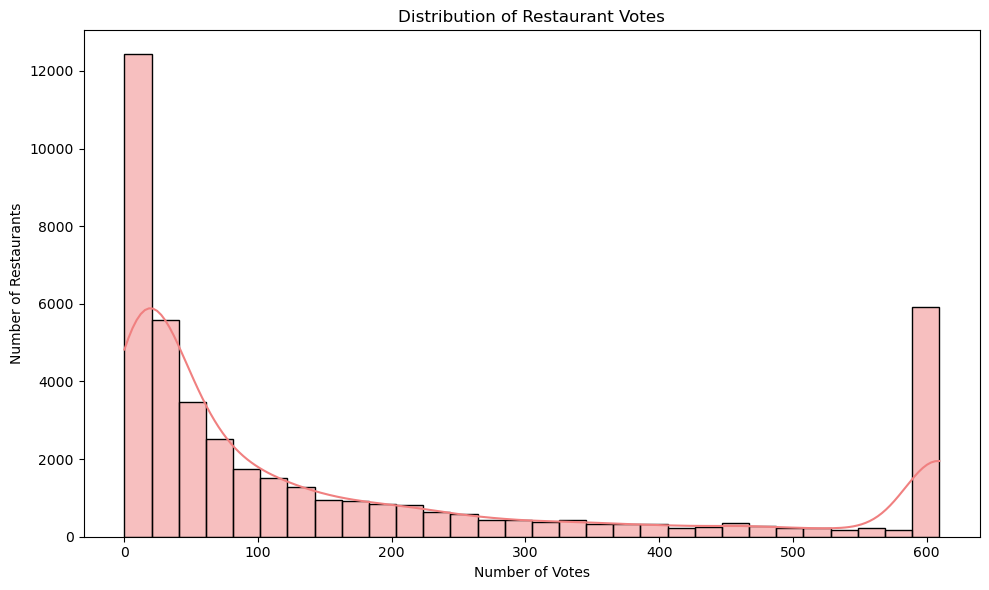

In [28]:
# Distribution of Votes (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(df['votes'], bins=30, kde=True, color='lightcoral')
plt.title('Distribution of Restaurant Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Number of Restaurants')
plt.tight_layout()
plt.show()


--- Relationship Between Votes, Cost, and Rating ---


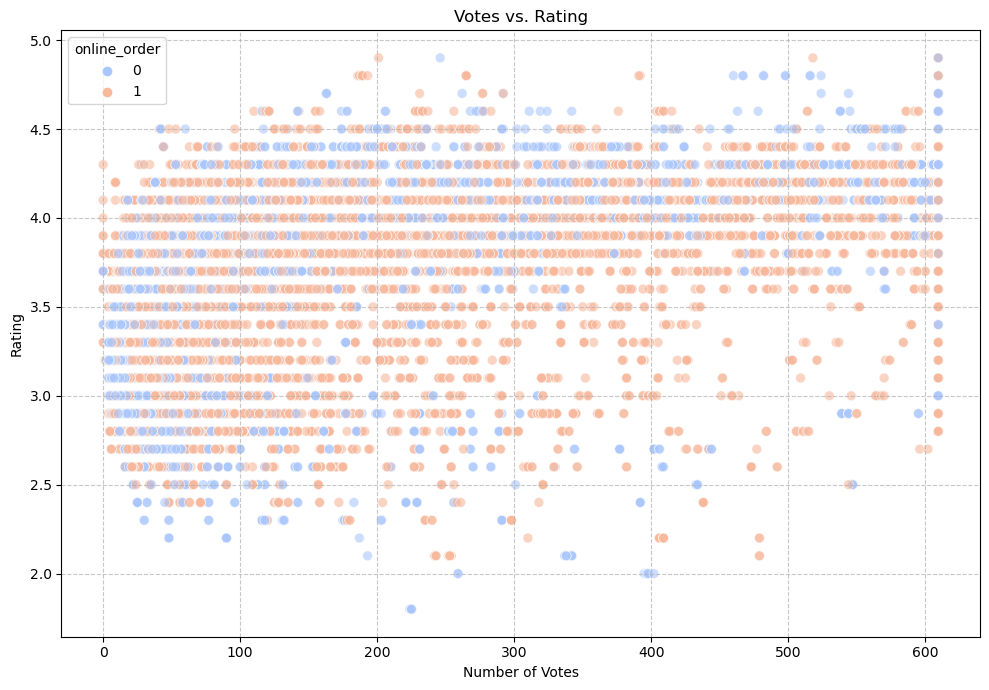

In [29]:
# 7.3. Relationship Between Votes, Cost, and Rating
print("\n--- Relationship Between Votes, Cost, and Rating ---")
# Votes vs. Rating Scatter Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x='votes', y='rate', data=df, alpha=0.6, hue='online_order', palette='coolwarm', s=50)
plt.title('Votes vs. Rating')
plt.xlabel('Number of Votes')
plt.ylabel('Rating')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


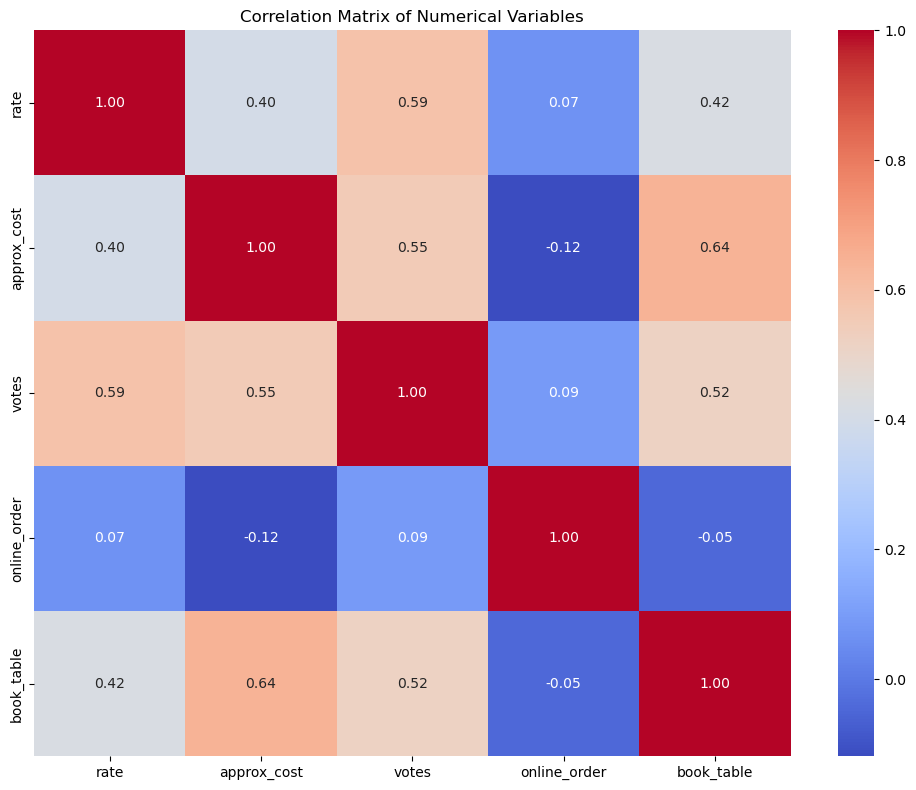

In [30]:

# Correlation Heatmap for All Numerical Variables
numerical_cols = ['rate', 'approx_cost', 'votes', 'online_order', 'book_table']
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()